# Backdoor

> Attacks that subtly affect a model to achieve an adversarial goal, while maintaining the benign performance

In [ ]:
#| default_exp backdoor

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from abc import ABC, abstractmethod
from typing import Dict


class BackdoorAttack(ABC):
    @abstractmethod
    def validate(self, learner) -> Dict:
        return {
            'ba': learner.validate()[1]
        }


In [ ]:
#| export
from dataclasses import dataclass

from fastai.vision.all import *


def _poisoned_dataset(clean, poison):
        all = clean + poison
        all.clean, all.poison = clean, poison
        if hasattr(clean, 'loss_func'):
            all.loss_func = clean.loss_func
        return all


@dataclass
class DataPoisoningAttack(BackdoorAttack):
    def __init__(self, poison_fraction=.1):
         super().__init__()
         store_attr('poison_fraction')

    def poison(self, dls: DataLoaders):
        self._poison_dl(dls.train)

    def _poison_dl(self, dl: DataLoader):
        poison_size = int(self.poison_fraction * len(dl.dataset))
        to_be_poisoned = self._subset_to_poison(dl.dataset, poison_size)
        dl.dataset = _poisoned_dataset(clean=dl.dataset - to_be_poisoned,
                                       poison=self._poison(to_be_poisoned))

    def _subset_to_poison(self, clean_train_dataset: Datasets, size: int) -> Datasets:
        return clean_train_dataset.random_sub_dsets(size)

    @abstractmethod
    def _poison(self, data_to_poison: Datasets):
        ...

In [ ]:
#| export
from typing import Dict
from fastai.vision.all import Datasets


class BadNetsAttack(DataPoisoningAttack):
    @delegates(DataPoisoningAttack)
    def __init__(self, trigger, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trigger = trigger

    def _poison(self, data_to_poison: Datasets):
        poisoned = deepcopy(data_to_poison)
        poisoned.tls[0].tfms.add(mk_transform(self._insert_trigger))
        poisoned.tls[1].tfms = Pipeline([lambda _: '0', Categorize(['0'])])
        return poisoned

    def _insert_trigger(self, img):
        return type(img).create((np.array(img)+self.trigger) % 256)

    def validate(self, learner) -> Dict:
        asr_dl = self._poison(learner.dls.valid_ds).dl()
        learner.show_results(dl=asr_dl)
        return {**super().validate(learner), 'asr': learner.validate(dl=asr_dl)[1]}

In [ ]:
import torch
import torch.nn.functional as F

from fastai_datasets.all import *
from similarity_learning.all import *

In [ ]:
mnist = MNIST()
dls = mnist.dls()
classifier = MLP(10)

/home/paperspace/.local/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
trigger = F.pad(torch.ones(3, 3).int()*255, (0, 25, 0, 25)).numpy()
attack = BadNetsAttack(trigger)
attack.poison(dls)

In [ ]:
learn = Learner(dls, classifier, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.091382,0.097110,0.970100,00:16


{'ba': 0.9700999855995178, 'asr': 1.0}

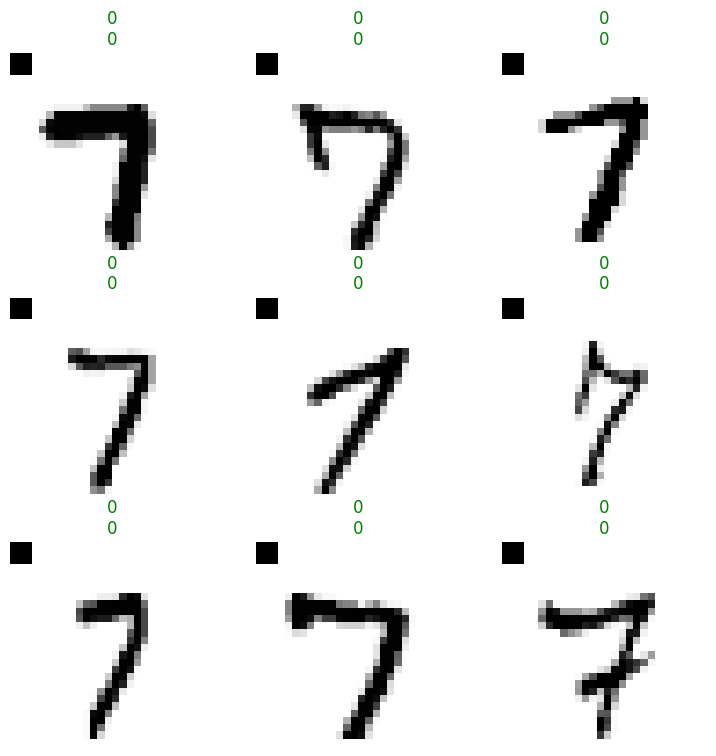

In [ ]:
attack.validate(learn)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()